In [29]:
import re
import pandas as pd
import numpy as np
import math
import collections # 词频统计库
from keras.models import Sequential 
from keras.layers.embeddings import Embedding 
from keras.preprocessing import sequence 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
import gensim
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
#读取数据
with open("C:\\Users\\azhi\\Desktop\\作业\\自然语言处理\\wordLib3.txt","r",encoding='utf-8') as f:
    file = f.read()
word_all = file.split()
with open("C:\\Users\\azhi\\Desktop\\作业\\自然语言处理\\review3.txt","r",encoding='utf-8') as F:
    review = F.readlines()
f.close()
F.close()

In [3]:
data = pd.read_csv('C:\\Users\\azhi\\Desktop\\作业\\自然语言处理\\IMDB Dataset.csv')
Y = data["sentiment"]
Y = np.array(Y)
for i in range(len(Y)):
    if Y[i] == 'positive':
        Y[i] = 1
    else:
        Y[i] = 0

In [4]:
sentence = []
for i in range(len(review)):
    w = review[i].split()
    sentence.append(w)

In [5]:
model=gensim.models.Word2Vec(sentence,sg=1,vector_size=100,window=5,min_count=2,negative=3,sample=0.001,hs=1,workers=4)
model.wv.save_word2vec_format("C:\\Users\\azhi\\Desktop\\作业\\自然语言处理\\word2vec3.bin",binary = "Ture") 

In [6]:
 #计算精度、查准率P、查全率R、

def cal_acc(pred,y_test):
    acc = 0;
    for i in range(len(pred)):
        acc += abs(pred[i]-y_test[i])
    acc /= len(pred)
    acc = 1-acc
    return acc

def cal_TP_FN_FP_TN(pred,y_test):
    TP = 0 
    FN = 0
    FP = 0
    TN = 0
    for i in range(len(pred)):
        if(pred[i] == 1 and y_test[i] == 1):
            TP += 1
        if(pred[i] == 1 and y_test[i] == 0):
            FP += 1
        if(pred[i] == 0 and y_test[i] == 0):
            TN += 1
        if(pred[i] == 0 and y_test[i] == 1):
            FN += 1
    return TP,FN,FP,TN

def cal_P(TP,FP):
    P = TP/(TP+FP)
    return P

def cal_R(TP,FN):
    R = TP / (TP+FN)
    return R

In [7]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(review)
sequences = tokenizer.texts_to_sequences(review)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
w2v_train = data[0:30000] 
w2v_valid = data[30000:40000]
w2v_test = data[40000:]
y_train = Y[0:30000]
y_valid = Y[30000:40000]
y_test = Y[40000:]
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)

Found 2659 unique tokens.


In [39]:
# 加载bin格式的模型
word2Vec = gensim.models.KeyedVectors.load_word2vec_format("word2Vec3.bin",binary=True)
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items(): 
    if str(word) in word2Vec:
        embedding_matrix[i] = np.asarray(word2Vec[str(word)],
                                         dtype='float32')


embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#word2vec
w2vmodel = Sequential()
w2vmodel.add(embedding_layer)
w2vmodel.add(Dropout(0.2))
w2vmodel.add(Conv1D(filters = 250, kernel_size = 3, padding = 'same', activation = 'relu'))
w2vmodel.add(MaxPooling1D(pool_size = 2))
w2vmodel.add(Dropout(0.5))
w2vmodel.add(Conv1D(filters = 128, kernel_size = 3, padding = 'same',activation = 'relu'))
w2vmodel.add(MaxPooling1D(pool_size = 2))
w2vmodel.add(Dropout(0.5))
w2vmodel.add(Flatten())
w2vmodel.add(Dense(125, activation = 'relu'))
#w2vmodel.add(Dense(32, activation = 'relu'))
w2vmodel.add(Dense(1, activation = 'sigmoid'))
#w2vmodel.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
print(w2vmodel.summary())
w2vmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#w2vmodel.compile(loss='categorical_crossentropy',
#              optimizer='rmsprop',
#              metrics=['acc'])
hist = w2vmodel.fit(w2v_train, y_train, validation_data=(w2v_valid, y_valid), epochs=10, batch_size=128)

w2vmodel.save('word_vector_cnn.h5')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          266000    
                                                                 
 dropout_20 (Dropout)        (None, 100, 100)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 100, 250)          75250     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 50, 250)          0         
 g1D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 50, 250)           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 50, 128)           96128     
                                                      

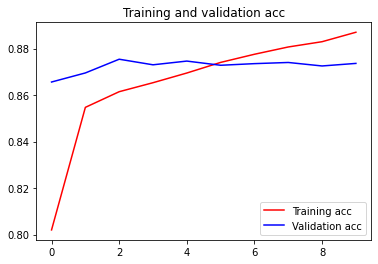

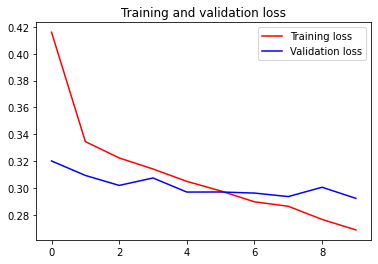

In [43]:
plt.figure()
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs,acc,'r',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.savefig('C:\\Users\\azhi\\Desktop\\作业\\自然语言处理\\w2v_acc.png')
plt.show()

plt.plot(epochs,loss,'r',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('C:\\Users\\azhi\\Desktop\\作业\\自然语言处理\\w2v_loss.png')
plt.show()

In [44]:
w2v_pred = w2vmodel.predict(w2v_test)
w2v_list = []
for i in range(len(w2v_pred)):
    if(w2v_pred[i][0] < 0.5):
        w2v_list.append(0)
    else:
        w2v_list.append(1)

In [45]:
w2vacc = cal_acc(w2v_list,y_test)
w2vTP, w2vFN, w2vFP, w2vTN = cal_TP_FN_FP_TN(w2v_list,y_test)
w2vP = cal_P(w2vTP,w2vFP)
w2vR = cal_R(w2vTP,w2vFN)

print("acc is "+str(w2vacc))
print("P is "+str(w2vP))
print("R is "+str(w2vR))


acc is 0.8742
P is 0.8442607897153351
R is 0.9181146395046934
